In [ ]:
## Loading Libraries

import sys
import pandas as pd
import sklearn
import platform
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report



## ML
! pip install tensorflow
! pip install tensorflow_hub
! pip install tensorflow-text
import tensorflow as tf
print(tf.__version__)
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow.keras


### Testing BERT
! pip install transformers
from tqdm.auto import tqdm
import transformers
from transformers import AutoTokenizer,TFDistilBertModel, DistilBertConfig, BertTokenizer, DistilBertTokenizer
from transformers import TFAutoModel
from transformers import DefaultDataCollator




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 80.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 95.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 43.1 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorboard
    Fou

In [ ]:
## Loading dataset
from google.colab import files
uploaded = files.upload()
import io


Saving product_category_data.csv to product_category_data.csv


In [ ]:
df = pd.read_csv(io.BytesIO(uploaded['product_category_data.csv']))

In [ ]:
## First 5 rows
df.head(10)

,name,top_category,sub_category,label
0,la bold 20,rokok,rokok,32
1,mustang,rokok,rokok,32
2,envio mild,rokok,rokok,32
3,aqua 600ml,air minum dalam kemasan,botol,0
4,bodrexin,obat obatan,obat kaplet,21
5,la bold 12,rokok,rokok,32
6,bodrex,obat obatan,obat kaplet,21
7,extrajoss,minuman sachet,minuman energy,19
8,dunhill mild 16,rokok,rokok,32
9,apache filter 12,rokok,rokok,32


## Data Summary

In [ ]:
## Data Summary
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22655 entries, 0 to 22654
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   name          22655 non-null  object
 1   top_category  22655 non-null  object
 2   sub_category  22655 non-null  object
dtypes: object(3)
memory usage: 531.1+ KB


## Bert Model - Top_Category

In [ ]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
## Encode labels in column 'top_category'
df['label'] = label_encoder.fit_transform(df['top_category'])

In [ ]:
label_mapping = pd.DataFrame({
    'Original Label': label_encoder.classes_,
    'Encoded Label': range(len(label_encoder.classes_))
})

In [ ]:
print(label_mapping)

                    Original Label  Encoded Label
0          air minum dalam kemasan              0
1             alat perawatan tubuh              1
2                 alat pertukangan              2
3                              atk              3
4                    bahan makanan              4
5                    bahan masakan              5
6                      bahan pokok              6
7                      buah buahan              7
8                      bumbu tabur              8
9                          koleksi              9
10                   korek api gas             10
11                    makanan bayi             11
12                 makanan instant             12
13                  makanan kaleng             13
14                 makanan protein             14
15                  makanan ringan             15
16                 makanan sarapan             16
17                   minuman bubuk             17
18           minuman dalam kemasan             18


In [ ]:
df[['label', 'top_category']].head()


,label,top_category
0,32,rokok
1,32,rokok
2,32,rokok
3,0,air minum dalam kemasan
4,21,obat obatan


In [ ]:
max(df['label'])

41

In [ ]:
min(df['label'])

0

In [ ]:

## Set parameters for the model
params = {
    "bert": "distilbert-base-multilingual-cased",
    "num_labels":42 ,
    "return_tensors": "tf",
    "batch_size": 32,
    "epochs": 25,
    "padding":"max_length",
    "max_length":100,
    "truncation": True

}

In [ ]:
## define tokenize_function
def tokenize_function(examples):
  tokenizer = AutoTokenizer.from_pretrained(params['bert'], lowercase=True)
  return tokenizer(examples["name"], padding=params["padding"], truncation=params["truncation"], max_length= params["max_length"])

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-multilingual-cased", lowercase=True)
tokenizer(["la bold 20", "mustang", "envio mild", "aqua 600ml"], padding="max_length", truncation=True, max_length=5)




{'input_ids': [[101, 10109, 78241, 10197, 102], [101, 14982, 11889, 102, 0], [101, 10110, 18574, 89176, 102], [101, 87487, 11908, 11796, 102]], 'attention_mask': [[1, 1, 1, 1, 1], [1, 1, 1, 1, 0], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1]]}

In [ ]:
## Train_test split
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size = 0.1)

In [ ]:
## Convert into Dataset format
! pip install datasets
from datasets import load_dataset
from datasets import Dataset, DatasetDict
dataset_dict = {
    'train': Dataset.from_pandas(train_df),
    'test': Dataset.from_pandas(test_df),
}

dataset = DatasetDict(dataset_dict)

print(dataset)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.3 MB/s eta 0:00:00
DatasetDict({
    train: Dataset({
        features: ['name', 'top_category', 'sub_category', 'label', '__index_level_0__'],
        num_rows: 20389
    })
    test: Dataset({
        features: ['name', 'top_category', 'sub_category', 'label', '__index_level_0__'],
        num_rows: 2266
    })
})


In [ ]:

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['name', 'top_category', 'sub_category', 'label', '__index_level_0__'],
        num_rows: 20389
    })
    test: Dataset({
        features: ['name', 'top_category', 'sub_category', 'label', '__index_level_0__'],
        num_rows: 2266
    })
})


In [ ]:
dataset_dict

{'train': Dataset({
     features: ['name', 'top_category', 'sub_category', 'label', '__index_level_0__'],
     num_rows: 20389
 }),
 'test': Dataset({
     features: ['name', 'top_category', 'sub_category', 'label', '__index_level_0__'],
     num_rows: 2266
 })}

In [ ]:
## Remove unnecessary column.
dataset['train'] = dataset['train'].remove_columns('__index_level_0__')
dataset['test'] = dataset['test'].remove_columns('__index_level_0__')


In [ ]:
dataset['test']

Dataset({
    features: ['name', 'top_category', 'sub_category', 'label'],
    num_rows: 2266
})

In [ ]:
## Tokenize train and test set
tokenized_datasets = dataset.map(tokenize_function)
small_train_dataset = tokenized_datasets["train"]
small_test_dataset = tokenized_datasets["test"]

Map:   0%|          | 0/20389 [00:00<?, ? examples/s]

Map:   0%|          | 0/2266 [00:00<?, ? examples/s]

In [ ]:

# Transform data into tensorflow format for test set
data_collator = DefaultDataCollator(return_tensors=params['return_tensors'])

tf_test_dataset = small_test_dataset.to_tf_dataset(
      columns=["attention_mask", "input_ids"],
      label_cols=["label"],
      shuffle=False,
      collate_fn=data_collator,
      batch_size=params['batch_size'],)

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:400: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [ ]:
## set up k-fold cross validation
from sklearn.model_selection import KFold
k = 5
kf = KFold(n_splits=k, shuffle=True)

In [ ]:
## Train Bert model with k-cross validation

import tensorflow as tf
from transformers import TFAutoModelForSequenceClassification

clf_report = []
for fold, (train_index, val_index) in enumerate(kf.split(small_train_dataset)):
  # Get the training and validation datasets for the current fold
  train_fold = small_train_dataset.select(train_index)
  val_fold = small_train_dataset.select(val_index)
  # Transform data into tensorflow format
  tf_train_dataset = train_fold.to_tf_dataset(
      columns=["attention_mask", "input_ids"],
      label_cols=["label"],
      shuffle=True,
      collate_fn=data_collator,
      batch_size=params['batch_size'],)

  tf_val_dataset = val_fold.to_tf_dataset(
      columns=["attention_mask", "input_ids"],
      label_cols=["label"],
      shuffle=False,
      collate_fn=data_collator,
      batch_size=params['batch_size'],)

  ## Initialize bert model
  bert = TFAutoModelForSequenceClassification.from_pretrained(params['bert'], num_labels=params['num_labels'])
  bert.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=tf.metrics.SparseCategoricalAccuracy(),)

  # Fit model
  history = bert.fit(tf_train_dataset, validation_data=tf_val_dataset, epochs=params['epochs'])
  ## predict on validation set
  val_predictions = bert.predict(tf_val_dataset)
  val_predicted_labels = np.argmax(val_predictions.logits, axis=1)
  val_true_labels = val_fold['label']

  # Classification report
  clf = classification_report(val_true_labels, val_predicted_labels, output_dict = True)
  clf = pd.DataFrame(clf).transpose()
  clf_report.append(clf)

  ## clean memry session
  # del bert
  #   tf.keras.backend.clear_session()







Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/25
510/510 [==============================] - 195s 335ms/step - loss: 1.3667 - sparse_categorical_accuracy: 0.6713 - val_loss: 0.4905 - val_sparse_categorical_accuracy: 0.8931
Epoch 2/25
510/510 [==============================] - 171s 336ms/step - loss: 0.3429 - sparse_categorical_accuracy: 0.9201 - val_loss: 0.3330 - val_sparse_categorical_accuracy: 0.9203
Epoch 3/25
510/510 [==============================] - 171s 336ms/step - loss: 0.1967 - sparse_categorical_accuracy: 0.9483 - val_loss: 0.3077 - val_sparse_categorical_accuracy: 0.9218
Epoch 4/25
510/510 [==============================] - 171s 336ms/step - loss: 0.1349 - sparse_categorical_accuracy: 0.9632 - val_loss: 0.2859 - val_sparse_categorical_accuracy: 0.9331
Epoch 5/25
510/510 [==============================] - 171s 336ms/step - loss: 0.0935 - sparse_categorical_accuracy: 0.9744 - val_loss: 0.2910 - val_sparse_categorical_accuracy: 0.9348
Epoch 6/25
510/510 [==============================] - 171s 336ms/step - loss: 0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.p

Epoch 1/25
510/510 [==============================] - 194s 340ms/step - loss: 1.3287 - sparse_categorical_accuracy: 0.6883 - val_loss: 0.5198 - val_sparse_categorical_accuracy: 0.8818
Epoch 2/25
510/510 [==============================] - 172s 337ms/step - loss: 0.3315 - sparse_categorical_accuracy: 0.9205 - val_loss: 0.3664 - val_sparse_categorical_accuracy: 0.9122
Epoch 3/25
510/510 [==============================] - 171s 336ms/step - loss: 0.1873 - sparse_categorical_accuracy: 0.9514 - val_loss: 0.3201 - val_sparse_categorical_accuracy: 0.9198
Epoch 4/25
510/510 [==============================] - 172s 336ms/step - loss: 0.1220 - sparse_categorical_accuracy: 0.9676 - val_loss: 0.3036 - val_sparse_categorical_accuracy: 0.9277
Epoch 5/25
510/510 [==============================] - 171s 336ms/step - loss: 0.0998 - sparse_categorical_accuracy: 0.9711 - val_loss: 0.3272 - val_sparse_categorical_accuracy: 0.9291
Epoch 6/25
510/510 [==============================] - 171s 336ms/step - loss: 0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

Epoch 1/25
510/510 [==============================] - 193s 339ms/step - loss: 1.3697 - sparse_categorical_accuracy: 0.6721 - val_loss: 0.4909 - val_sparse_categorical_accuracy: 0.8843
Epoch 2/25
510/510 [==============================] - 171s 336ms/step - loss: 0.3479 - sparse_categorical_accuracy: 0.9172 - val_loss: 0.3361 - val_sparse_categorical_accuracy: 0.9156
Epoch 3/25
510/510 [==============================] - 171s 336ms/step - loss: 0.1911 - sparse_categorical_accuracy: 0.9512 - val_loss: 0.2978 - val_sparse_categorical_accuracy: 0.9257
Epoch 4/25
510/510 [==============================] - 171s 336ms/step - loss: 0.1308 - sparse_categorical_accuracy: 0.9649 - val_loss: 0.2673 - val_sparse_categorical_accuracy: 0.9375
Epoch 5/25
510/510 [==============================] - 171s 336ms/step - loss: 0.0978 - sparse_categorical_accuracy: 0.9728 - val_loss: 0.3128 - val_sparse_categorical_accuracy: 0.9318
Epoch 6/25
510/510 [==============================] - 171s 336ms/step - loss: 0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:400: FutureWarning: Th

Epoch 1/25
510/510 [==============================] - 193s 339ms/step - loss: 1.3822 - sparse_categorical_accuracy: 0.6710 - val_loss: 0.4593 - val_sparse_categorical_accuracy: 0.8899
Epoch 2/25
510/510 [==============================] - 171s 336ms/step - loss: 0.3518 - sparse_categorical_accuracy: 0.9174 - val_loss: 0.2790 - val_sparse_categorical_accuracy: 0.9274
Epoch 3/25
510/510 [==============================] - 171s 336ms/step - loss: 0.2000 - sparse_categorical_accuracy: 0.9505 - val_loss: 0.2584 - val_sparse_categorical_accuracy: 0.9321
Epoch 4/25
510/510 [==============================] - 171s 336ms/step - loss: 0.1241 - sparse_categorical_accuracy: 0.9670 - val_loss: 0.2758 - val_sparse_categorical_accuracy: 0.9343
Epoch 5/25
510/510 [==============================] - 171s 336ms/step - loss: 0.0991 - sparse_categorical_accuracy: 0.9728 - val_loss: 0.2915 - val_sparse_categorical_accuracy: 0.9318
Epoch 6/25
510/510 [==============================] - 171s 336ms/step - loss: 0.

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:400: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with 

Epoch 1/25
510/510 [==============================] - 193s 338ms/step - loss: 1.3143 - sparse_categorical_accuracy: 0.6862 - val_loss: 0.4595 - val_sparse_categorical_accuracy: 0.8913
Epoch 2/25
510/510 [==============================] - 171s 335ms/step - loss: 0.3249 - sparse_categorical_accuracy: 0.9228 - val_loss: 0.3186 - val_sparse_categorical_accuracy: 0.9235
Epoch 3/25
510/510 [==============================] - 171s 336ms/step - loss: 0.1821 - sparse_categorical_accuracy: 0.9511 - val_loss: 0.2822 - val_sparse_categorical_accuracy: 0.9325
Epoch 4/25
510/510 [==============================] - 172s 336ms/step - loss: 0.1239 - sparse_categorical_accuracy: 0.9676 - val_loss: 0.2754 - val_sparse_categorical_accuracy: 0.9372
Epoch 5/25
510/510 [==============================] - 171s 335ms/step - loss: 0.0911 - sparse_categorical_accuracy: 0.9744 - val_loss: 0.2676 - val_sparse_categorical_accuracy: 0.9414
Epoch 6/25
510/510 [==============================] - 171s 335ms/step - loss: 0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Get average classification_report of k fold
concatenated_clf_report = pd.concat(clf_report)
average_clf_report = concatenated_clf_report.groupby(concatenated_clf_report.index).mean()
average_clf_report

,precision,recall,f1-score,support
0,0.927754,0.930582,0.928484,64.000000
1,0.750000,0.611111,0.522222,2.000000
10,0.942857,0.942857,0.933333,5.000000
11,0.620000,0.590000,0.600000,3.800000
12,0.955724,0.958187,0.956775,194.200000
13,0.980952,0.970811,0.975033,20.000000
14,0.800000,0.800000,0.800000,2.000000
15,0.961309,0.970534,0.965843,1022.800000
16,1.000000,0.960000,0.977778,3.800000
17,0.787931,0.767564,0.774282,54.000000


In [ ]:
## Predict of validation set
output_logits = bert.predict(tf_test_dataset).logits
pred_labels = np.argmax(output_logits, axis=-1)

71/71 [==============================] - 8s 106ms/step


In [ ]:
## Classification_report
print(sklearn.metrics.classification_report(small_test_dataset['label'],pred_labels))

              precision    recall  f1-score   support

           0       0.94      0.85      0.89        34
           2       0.67      1.00      0.80         2
           3       0.83      0.83      0.83         6
           4       0.90      0.95      0.93        60
           5       0.97      0.96      0.96       228
           6       0.94      1.00      0.97        15
           7       1.00      0.83      0.91         6
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         2
          11       0.50      0.50      0.50         2
          12       0.93      0.98      0.95       103
          13       1.00      1.00      1.00        12
          14       1.00      1.00      1.00         1
          15       0.98      0.95      0.97       569
          16       0.00      0.00      0.00         0
          17       0.81      0.70      0.75        30
          18       0.91    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


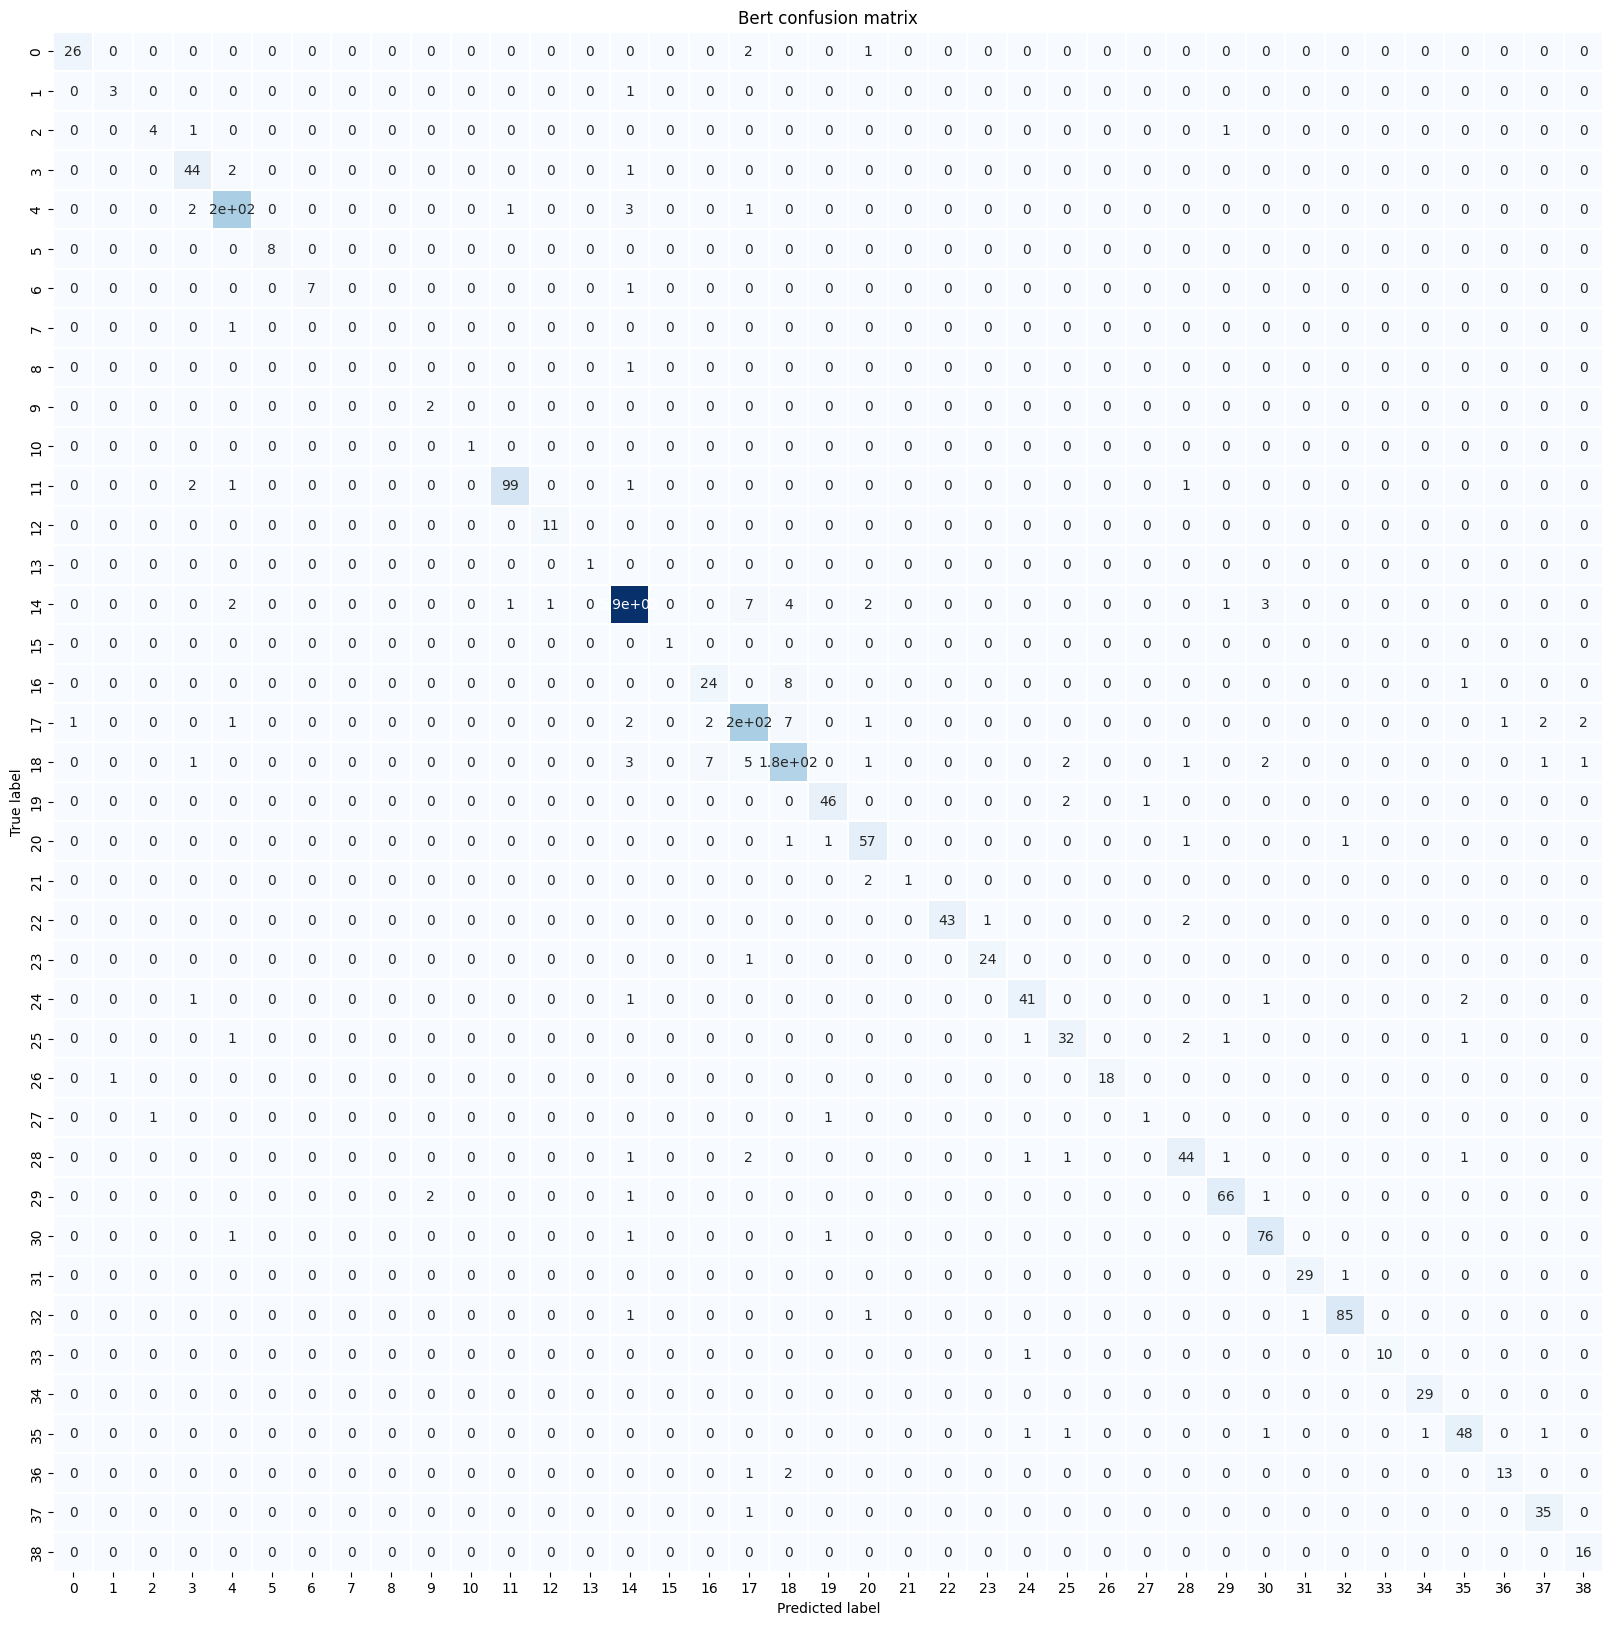

In [ ]:
## Confusion matrix
cm_bert = sklearn.metrics.confusion_matrix(small_test_dataset['label'],pred_labels)
plt.figure(figsize=(20,20))
sns.heatmap(cm_bert, annot = True,  linewidths=.3, cbar =None, annot_kws={'size': 10}, cmap='Blues')
plt.title('Bert confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label');


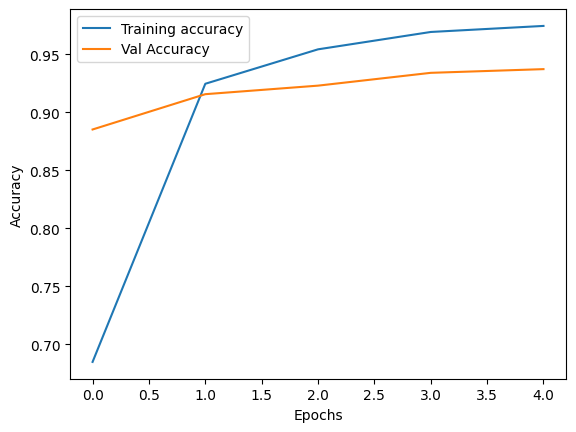

In [ ]:
## Plot train and test accuracy
plt.plot(history.history['sparse_categorical_accuracy'], label = 'Training accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label = 'Val Accuracy')
plt.xlabel("Epochs")
plt.ylabel('Accuracy')
plt.legend()
plt.show()

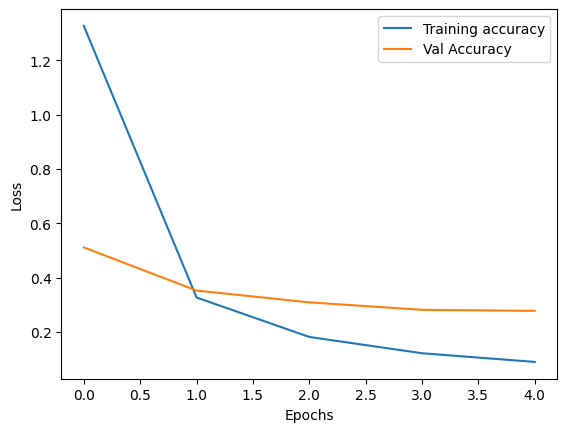

In [ ]:
## Plot train and test loss
plt.plot(history.history['loss'], label = 'Training accuracy')
plt.plot(history.history['val_loss'], label = 'Val Accuracy')
plt.xlabel("Epochs")
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Save the weights
bert.save_weights('./checkpointss/my_checkpoint')

In [ ]:
# from google.colab import files
# files.download('/checkpoints/my_checkpoint.data-00000-of-00001')

In [ ]:
# # Restore the weights
# new_model.load_weights('./checkpoints/my_checkpoint')

Train the model on the whole training set (training + validation)

In [ ]:
tf_train_val_dataset = small_train_dataset.to_tf_dataset(
    columns=['attention_mask', "input_ids"],
    label_cols=["label"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=params['batch_size'],
)

In [ ]:
import tensorflow as tf
from transformers import TFAutoModelForSequenceClassification
bert = TFAutoModelForSequenceClassification.from_pretrained(params['bert'], num_labels=params['num_labels'])
bert.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=tf.metrics.SparseCategoricalAccuracy(),)
history = bert.fit(tf_train_val_dataset, epochs=params['epochs'])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/5
638/638 [==============================] - 221s 303ms/step - loss: 1.1872 - sparse_categorical_accuracy: 0.7165
Epoch 2/5
638/638 [==============================] - 197s 308ms/step - loss: 0.2916 - sparse_categorical_accuracy: 0.9284
Epoch 3/5
638/638 [==============================] - 198s 311ms/step - loss: 0.1671 - sparse_categorical_accuracy: 0.9574
Epoch 4/5
638/638 [==============================] - 198s 311ms/step - loss: 0.1152 - sparse_categorical_accuracy: 0.9692
Epoch 5/5
638/638 [==============================] - 198s 311ms/step - loss: 0.0889 - sparse_categorical_accuracy: 0.9759


In [ ]:
## Predict of validation set
output_logits = bert.predict(tf_test_dataset).logits
pred_labels = np.argmax(output_logits, axis=-1)

71/71 [==============================] - 9s 105ms/step


In [ ]:
## Classification_report
print(sklearn.metrics.classification_report(small_test_dataset['label'],pred_labels))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        29
           2       1.00      0.75      0.86         4
           3       0.71      0.83      0.77         6
           4       0.81      0.94      0.87        47
           5       0.96      0.95      0.95       205
           6       0.89      1.00      0.94         8
           7       1.00      0.88      0.93         8
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1
          10       0.40      1.00      0.57         2
          11       0.50      1.00      0.67         1
          12       0.99      0.93      0.96       104
          13       0.92      1.00      0.96        11
          14       1.00      1.00      1.00         1
          15       0.96      0.96      0.96       610
          16       1.00      1.00      1.00         1
          17       0.64      0.64      0.64        33
          18       0.94    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


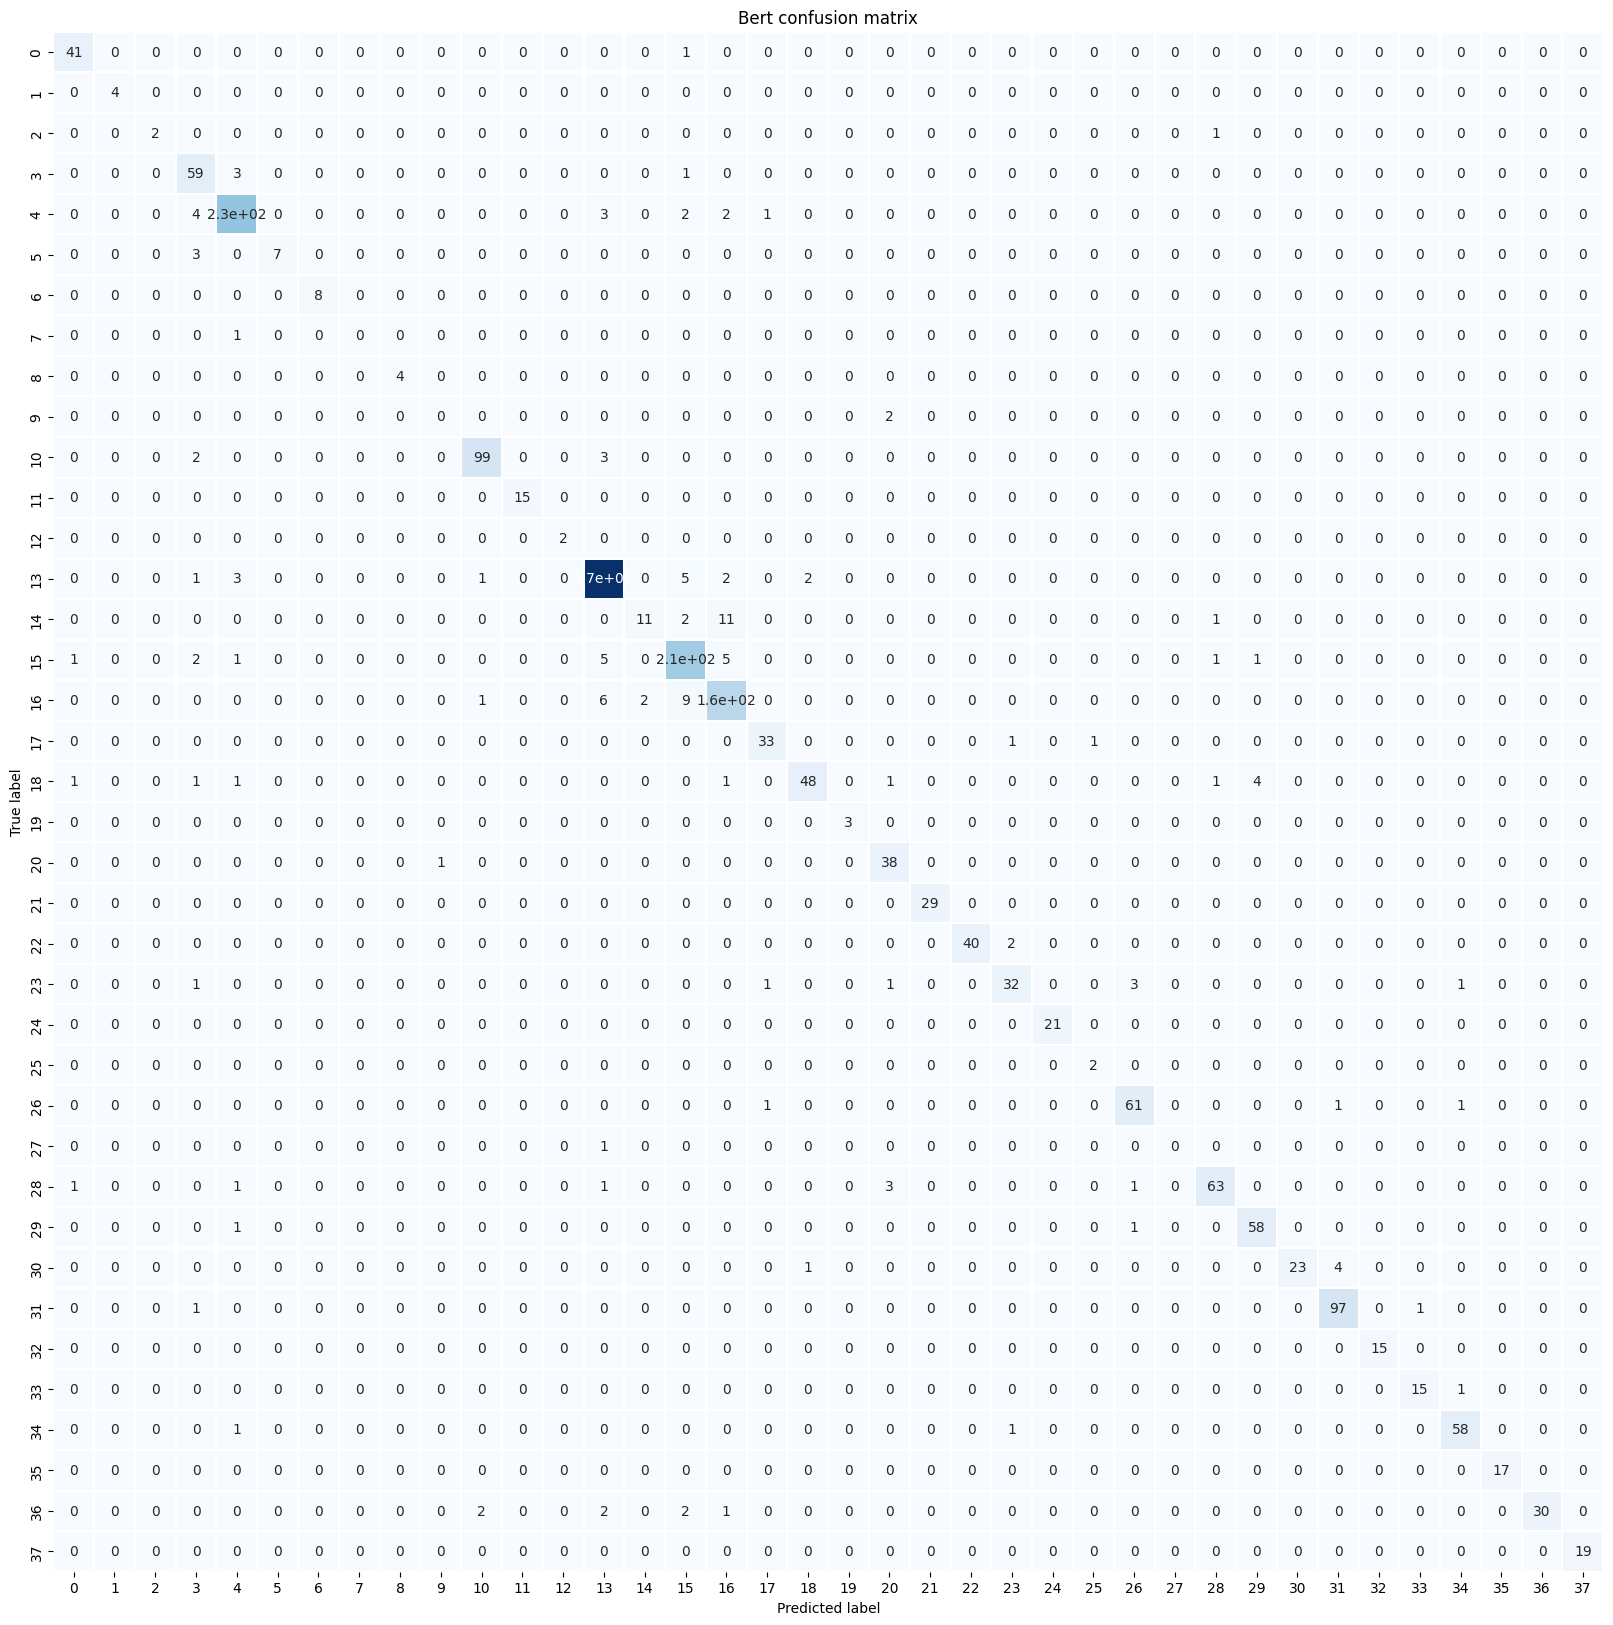

In [ ]:
## Confusion matrix
cm_bert = sklearn.metrics.confusion_matrix(small_test_dataset['label'],pred_labels)
plt.figure(figsize=(20,20))
sns.heatmap(cm_bert, annot = True,  linewidths=.3, cbar =None, annot_kws={'size': 10}, cmap='Blues')
plt.title('Bert confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label');


## Bert Model - Sub_category

In [ ]:
# df = pd.read_csv(io.BytesIO(uploaded['product_category_data.csv']))

In [ ]:
from sklearn import preprocessing
sub_label_encoder = preprocessing.LabelEncoder()
## Encode labels in column 'top_category'
df['label'] = sub_label_encoder.fit_transform(df['sub_category'])

In [ ]:
label_mapping = pd.DataFrame({
    'Original Label': sub_label_encoder.classes_,
    'Encoded Label': range(len(sub_label_encoder.classes_))
})
pd.set_option('display.max_rows', None)

In [ ]:
print(label_mapping)

            Original Label  Encoded Label
0                agar-agar              0
1                   amplop              1
2              aneka kecap              2
3             aneka sambal              3
4               antiseptik              4
5                bahan kue              5
6                   balsam              6
7                   balsem              7
8                  baterai              8
9                    bedak              9
10              bedak bayi             10
11                   beras             11
12           bihun instant             12
13            bihun kering             13
14                 biskuit             14
15             body lotion             15
16                  bohlam             16
17                   botol             17
18                   bubur             18
19              buku tulis             19
20        bumbu & penyedap             20
21                 cokelat             21
22                    cuka        

In [ ]:
max(df['label']) ## 185 labels

184

In [ ]:
## Set parameters for the model
params = {
    "bert": "distilbert-base-multilingual-cased",
    "num_labels":185 ,
    "return_tensors": "tf",
    "batch_size": 32,
    "epochs": 20,
    "padding":"max_length",
    "max_length":100,
    "truncation": True

}

In [ ]:
## define tokenize_function
def tokenize_function(examples):
    tokenizer = AutoTokenizer.from_pretrained(params['bert'])
    return tokenizer(examples["name"], padding=params["padding"], truncation=params["truncation"], max_length= params["max_length"])

In [ ]:
## Get X and y
from sklearn.model_selection import train_test_split
df = df[['name','label']]
train_df, test_df = train_test_split(df, test_size = 0.1, random_state = 42)

In [ ]:
! pip install datasets
from datasets import load_dataset
from datasets import Dataset, DatasetDict
dataset_dict = {
    'train': Dataset.from_pandas(train_df),
    'test': Dataset.from_pandas(test_df)
}

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.0 MB/s eta 0:00:00


In [ ]:
dataset = DatasetDict(dataset_dict)
print(dataset['train'])
dataset['train'] = dataset['train'].remove_columns('__index_level_0__')
dataset['test'] = dataset['test'].remove_columns('__index_level_0__')

print(dataset['train'][0])

Dataset({
    features: ['name', 'label', '__index_level_0__'],
    num_rows: 20389
})
{'name': 'ubm', 'label': 14}


In [ ]:
## Tokenize train and test set
tokenized_datasets = dataset.map(tokenize_function)
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42)
small_test_dataset = tokenized_datasets["test"].shuffle(seed=42)

Map:   0%|          | 0/20389 [00:00<?, ? examples/s]

Map:   0%|          | 0/2266 [00:00<?, ? examples/s]

In [ ]:
## Transform into tensorflow format for test set
from transformers import DefaultDataCollator
data_collator = DefaultDataCollator(return_tensors=params['return_tensors'])

tf_test_dataset = small_test_dataset.to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["label"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=params['batch_size'],)


/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:400: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [ ]:
## Build and train bert model


In [ ]:
## Set up K-cross validation
from sklearn.model_selection import KFold
k = 5
kf = KFold(n_splits=k, shuffle=True)

In [ ]:
## Train model with k-cross validation
import tensorflow as tf
from transformers import TFAutoModelForSequenceClassification
from transformers import DefaultDataCollator
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
data_collator = DefaultDataCollator(return_tensors=params['return_tensors'])

clf_report = []
for fold, (train_index, val_index) in enumerate(kf.split(small_train_dataset)):
  # Get the training and validation datasets for the current fold
  train_fold = small_train_dataset.select(train_index)
  val_fold = small_train_dataset.select(val_index)
  # Transform data into tensorflow format
  tf_train_dataset = train_fold.to_tf_dataset(
      columns=["attention_mask", "input_ids"],
      label_cols=["label"],
      shuffle=True,
      collate_fn=data_collator,
      batch_size=params['batch_size'],)

  tf_val_dataset = val_fold.to_tf_dataset(
      columns=["attention_mask", "input_ids"],
      label_cols=["label"],
      shuffle=False,
      collate_fn=data_collator,
      batch_size=params['batch_size'],)

  # Initialize the model
  bert = TFAutoModelForSequenceClassification.from_pretrained(params['bert'], num_labels=params['num_labels'])
  bert.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=tf.metrics.SparseCategoricalAccuracy(),)

  # Fit model
  history = bert.fit(tf_train_dataset, validation_data=tf_val_dataset, epochs=params['epochs'])
  ## predict on validation set
  val_predictions = bert.predict(tf_val_dataset)
  val_predicted_labels = np.argmax(val_predictions.logits, axis=1)
  val_true_labels = val_fold['label']

  # Classification report
  clf = classification_report(val_true_labels, val_predicted_labels, output_dict = True)
  clf = pd.DataFrame(clf).transpose()
  clf_report.append(clf)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/20
510/510 [==============================] - 191s 328ms/step - loss: 2.4488 - sparse_categorical_accuracy: 0.5285 - val_loss: 1.1460 - val_sparse_categorical_accuracy: 0.7859
Epoch 2/20
510/510 [==============================] - 168s 330ms/step - loss: 0.8974 - sparse_categorical_accuracy: 0.8191 - val_loss: 0.7612 - val_sparse_categorical_accuracy: 0.8404
Epoch 3/20
510/510 [==============================] - 168s 330ms/step - loss: 0.5513 - sparse_categorical_accuracy: 0.8781 - val_loss: 0.6102 - val_sparse_categorical_accuracy: 0.8654
Epoch 4/20
510/510 [==============================] - 168s 330ms/step - loss: 0.3758 - sparse_categorical_accuracy: 0.9114 - val_loss: 0.5482 - val_sparse_categorical_accuracy: 0.8720
Epoch 5/20
510/510 [==============================] - 168s 330ms/step - loss: 0.2681 - sparse_categorical_accuracy: 0.9335 - val_loss: 0.4903 - val_sparse_categorical_accuracy: 0.8923
Epoch 6/20
510/510 [==============================] - 168s 330ms/step - loss: 0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

Epoch 1/20
510/510 [==============================] - 189s 332ms/step - loss: 2.4222 - sparse_categorical_accuracy: 0.5323 - val_loss: 1.1369 - val_sparse_categorical_accuracy: 0.7818
Epoch 2/20
510/510 [==============================] - 168s 330ms/step - loss: 0.8956 - sparse_categorical_accuracy: 0.8179 - val_loss: 0.7639 - val_sparse_categorical_accuracy: 0.8359
Epoch 3/20
510/510 [==============================] - 168s 329ms/step - loss: 0.5565 - sparse_categorical_accuracy: 0.8766 - val_loss: 0.6167 - val_sparse_categorical_accuracy: 0.8578
Epoch 4/20
510/510 [==============================] - 168s 329ms/step - loss: 0.3725 - sparse_categorical_accuracy: 0.9119 - val_loss: 0.5444 - val_sparse_categorical_accuracy: 0.8779
Epoch 5/20
510/510 [==============================] - 168s 329ms/step - loss: 0.2644 - sparse_categorical_accuracy: 0.9342 - val_loss: 0.5185 - val_sparse_categorical_accuracy: 0.8865
Epoch 6/20
510/510 [==============================] - 168s 329ms/step - loss: 0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

Epoch 1/20
510/510 [==============================] - 189s 332ms/step - loss: 2.4452 - sparse_categorical_accuracy: 0.5221 - val_loss: 1.1726 - val_sparse_categorical_accuracy: 0.7717
Epoch 2/20
510/510 [==============================] - 168s 329ms/step - loss: 0.9029 - sparse_categorical_accuracy: 0.8153 - val_loss: 0.7588 - val_sparse_categorical_accuracy: 0.8409
Epoch 3/20
510/510 [==============================] - 168s 329ms/step - loss: 0.5518 - sparse_categorical_accuracy: 0.8782 - val_loss: 0.6238 - val_sparse_categorical_accuracy: 0.8612
Epoch 4/20
510/510 [==============================] - 168s 329ms/step - loss: 0.3781 - sparse_categorical_accuracy: 0.9110 - val_loss: 0.5666 - val_sparse_categorical_accuracy: 0.8695
Epoch 5/20
510/510 [==============================] - 168s 329ms/step - loss: 0.2689 - sparse_categorical_accuracy: 0.9343 - val_loss: 0.5266 - val_sparse_categorical_accuracy: 0.8781
Epoch 6/20
510/510 [==============================] - 168s 329ms/step - loss: 0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

Epoch 1/20
510/510 [==============================] - 190s 332ms/step - loss: 2.4110 - sparse_categorical_accuracy: 0.5309 - val_loss: 1.1642 - val_sparse_categorical_accuracy: 0.7663
Epoch 2/20
510/510 [==============================] - 168s 329ms/step - loss: 0.8881 - sparse_categorical_accuracy: 0.8182 - val_loss: 0.7881 - val_sparse_categorical_accuracy: 0.8325
Epoch 3/20
510/510 [==============================] - 168s 329ms/step - loss: 0.5478 - sparse_categorical_accuracy: 0.8774 - val_loss: 0.6437 - val_sparse_categorical_accuracy: 0.8644
Epoch 4/20
510/510 [==============================] - 168s 329ms/step - loss: 0.3707 - sparse_categorical_accuracy: 0.9136 - val_loss: 0.5573 - val_sparse_categorical_accuracy: 0.8779
Epoch 5/20
510/510 [==============================] - 168s 330ms/step - loss: 0.2602 - sparse_categorical_accuracy: 0.9339 - val_loss: 0.5228 - val_sparse_categorical_accuracy: 0.8838
Epoch 6/20
510/510 [==============================] - 168s 329ms/step - loss: 0.

In [ ]:
# Get average classification_report of k fold
concatenated_clf_report = pd.concat(clf_report)
average_clf_report = concatenated_clf_report.groupby(concatenated_clf_report.index).mean()
average_clf_report

,precision,recall,f1-score,support
0,0.904638,0.933079,0.917590,24.600000
1,1.000000,1.000000,1.000000,3.500000
10,0.905455,0.770000,0.820155,6.200000
100,0.308333,0.185714,0.200000,3.600000
101,0.500000,0.375000,0.416667,1.500000
...,...,...,...,...
98,0.643333,0.579048,0.602424,5.800000
99,0.803137,0.882344,0.839744,51.000000
accuracy,0.894159,0.894159,0.894159,0.894159
macro avg,0.785126,0.764967,0.759669,4077.800000


In [ ]:
## Predict of validation set
output_logits = bert.predict(tf_test_dataset).logits
pred_labels = np.argmax(output_logits, axis=-1)

71/71 [==============================] - 8s 107ms/step


In [ ]:
accuracy_score(small_test_dataset['label'],pred_labels)

0.9011473962930273

In [ ]:
## Classification_report
print(sklearn.metrics.classification_report(small_test_dataset['label'],pred_labels))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94        16
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00        23
           3       0.97      1.00      0.99        33
           4       0.93      0.95      0.94        78
           6       0.75      0.75      0.75         4
           7       0.50      1.00      0.67         1
           8       1.00      1.00      1.00         6
           9       1.00      0.50      0.67         4
          10       0.80      1.00      0.89         4
          11       1.00      1.00      1.00         6
          12       0.50      0.50      0.50         2
          13       0.83      0.83      0.83         6
          14       0.92      0.93      0.92       183
          15       0.00      0.00      0.00         0
          16       1.00      0.75      0.86         4
          17       0.69      0.77      0.73        35
          18       1.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

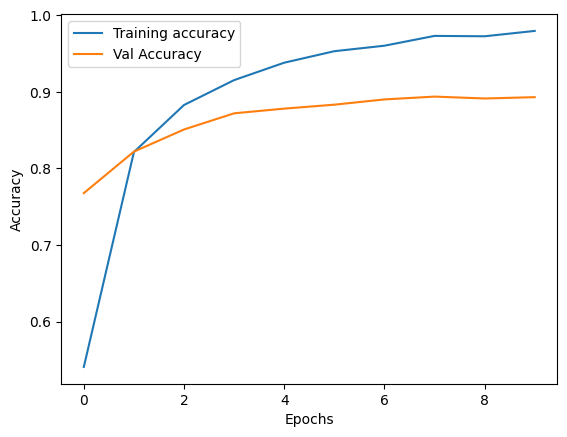

In [ ]:
## Plot train and test accuracy
plt.plot(history.history['sparse_categorical_accuracy'], label = 'Training accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label = 'Val Accuracy')
plt.xlabel("Epochs")
plt.ylabel('Accuracy')
plt.legend()
plt.show()

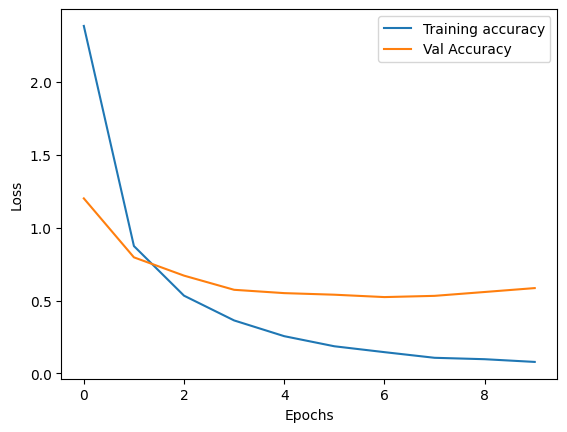

In [ ]:
## Plot train and test loss
plt.plot(history.history['loss'], label = 'Training accuracy')
plt.plot(history.history['val_loss'], label = 'Val Accuracy')
plt.xlabel("Epochs")
plt.ylabel('Loss')
plt.legend()
plt.show()

# Train the model on full train dataset (Without splitting train-validation set)

In [ ]:
params = {
    "bert": "distilbert-base-multilingual-cased",
    "num_labels":185 ,
    "return_tensors": "tf",
    "batch_size": 32,
    "epochs": 20,
    "padding":"max_length",
    "max_length":100,
    "truncation": True

}

In [ ]:
tf_train_val_dataset = small_train_dataset.to_tf_dataset(
    columns=['attention_mask', "input_ids"],
    label_cols=["label"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=params['batch_size'],
)

In [ ]:
import tensorflow as tf
from transformers import TFAutoModelForSequenceClassification
from transformers import DefaultDataCollator
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
bert = TFAutoModelForSequenceClassification.from_pretrained(params['bert'], num_labels=params['num_labels'])
bert.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=tf.metrics.SparseCategoricalAccuracy(),)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [ ]:
#  earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",
#                                                       patience = 3,
#                                                       restore_best_weights = True)
history = bert.fit(tf_train_val_dataset, epochs=params['epochs'])

Epoch 1/20
638/638 [==============================] - 223s 311ms/step - loss: 2.2040 - sparse_categorical_accuracy: 0.5729
Epoch 2/20
638/638 [==============================] - 199s 312ms/step - loss: 0.7664 - sparse_categorical_accuracy: 0.8393
Epoch 3/20
638/638 [==============================] - 199s 311ms/step - loss: 0.4637 - sparse_categorical_accuracy: 0.8921
Epoch 4/20
638/638 [==============================] - 199s 311ms/step - loss: 0.3176 - sparse_categorical_accuracy: 0.9206
Epoch 5/20
638/638 [==============================] - 199s 311ms/step - loss: 0.2269 - sparse_categorical_accuracy: 0.9391
Epoch 6/20
638/638 [==============================] - 199s 312ms/step - loss: 0.1688 - sparse_categorical_accuracy: 0.9535
Epoch 7/20
638/638 [==============================] - 199s 312ms/step - loss: 0.1341 - sparse_categorical_accuracy: 0.9612
Epoch 8/20
638/638 [==============================] - 199s 311ms/step - loss: 0.1137 - sparse_categorical_accuracy: 0.9669
Epoch 9/20
638/6

In [ ]:
## Predict of validation set
output_logits = bert.predict(tf_test_dataset).logits
pred_labels = np.argmax(output_logits, axis=-1)

71/71 [==============================] - 10s 114ms/step


In [ ]:
## Classification_report
print(sklearn.metrics.classification_report(small_test_dataset['label'],pred_labels))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87        11
           1       1.00      1.00      1.00         3
           2       1.00      0.96      0.98        23
           3       0.96      0.93      0.94        27
           4       0.91      0.97      0.94        69
           6       0.80      1.00      0.89         4
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         3
          10       1.00      0.57      0.73         7
          11       0.91      1.00      0.95        10
          12       0.00      0.00      0.00         2
          13       0.89      0.89      0.89         9
          14       0.96      0.89      0.92       170
          15       1.00      1.00      1.00         1
          16       1.00      1.00      1.00         4
          17       0.71      1.00      0.83        15
          18       1.00      0.67      0.80         3
          19       1.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [ ]:
df['name'].str.len().max()

89

Result of epoch = 10

In [ ]:
params = {
    "bert": "distilbert-base-multilingual-cased",
    "num_labels":185 ,
    "return_tensors": "tf",
    "batch_size": 32,
    "epochs": 10,
    "padding":"max_length",
    "max_length": 100,
    "truncation": True

}

In [ ]:
import tensorflow as tf
from transformers import TFAutoModelForSequenceClassification
from transformers import DefaultDataCollator
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
bert = TFAutoModelForSequenceClassification.from_pretrained(params['bert'], num_labels=params['num_labels'])
bert.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=tf.metrics.SparseCategoricalAccuracy(),)
history = bert.fit(tf_train_val_dataset, epochs=params['epochs'])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/10
638/638 [==============================] - 228s 310ms/step - loss: 2.1398 - sparse_categorical_accuracy: 0.5885
Epoch 2/10
638/638 [==============================] - 199s 312ms/step - loss: 0.7669 - sparse_categorical_accuracy: 0.8371
Epoch 3/10
638/638 [==============================] - 199s 311ms/step - loss: 0.4657 - sparse_categorical_accuracy: 0.8912
Epoch 4/10
638/638 [==============================] - 199s 311ms/step - loss: 0.3172 - sparse_categorical_accuracy: 0.9209
Epoch 5/10
638/638 [==============================] - 199s 311ms/step - loss: 0.2201 - sparse_categorical_accuracy: 0.9412
Epoch 6/10
638/638 [==============================] - 199s 311ms/step - loss: 0.1679 - sparse_categorical_accuracy: 0.9543
Epoch 7/10
638/638 [==============================] - 199s 311ms/step - loss: 0.1295 - sparse_categorical_accuracy: 0.9637
Epoch 8/10
638/638 [==============================] - 199s 311ms/step - loss: 0.1044 - sparse_categorical_accuracy: 0.9702
Epoch 9/10
638/6

In [ ]:
## Predict of validation set
output_logits = bert.predict(tf_test_dataset).logits
pred_labels = np.argmax(output_logits, axis=-1)

71/71 [==============================] - 11s 114ms/step


In [ ]:
## Classification_report
print(sklearn.metrics.classification_report(small_test_dataset['label'],pred_labels))

              precision    recall  f1-score   support

           0       0.90      0.82      0.86        11
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00        23
           3       1.00      0.96      0.98        27
           4       0.96      0.97      0.96        69
           6       0.80      1.00      0.89         4
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         3
          10       1.00      0.57      0.73         7
          11       0.91      1.00      0.95        10
          12       0.50      0.50      0.50         2
          13       0.89      0.89      0.89         9
          14       0.98      0.92      0.95       170
          15       1.00      1.00      1.00         1
          16       1.00      0.75      0.86         4
          17       0.62      1.00      0.77        15
          18       1.00      0.67      0.80         3
          19       1.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to cont

In [ ]:
train_df.label.value_counts().sort_values().head(20)

62     3
115    4
111    4
48     5
126    5
136    5
102    5
28     5
164    5
180    5
43     5
122    6
153    6
151    6
101    6
144    6
91     6
58     6
19     6
46     6
Name: label, dtype: int64

# Deep Checks Model Testing

Import DeepChecks

In [ ]:
import sys
!{sys.executable} -m pip install 'deepchecks[nlp]' -U --quiet #--user
!{sys.executable} -m pip install 'deepchecks[nlp-properties]' -U --quiet #--user

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 46.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 73.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 79.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 50.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 63.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... don

In [ ]:
from deepchecks.nlp import TextData
import torch
train = TextData(train_df.name, label=train_df['label'], task_type='text_classification',
                 metadata=train_df.drop(columns=['label', 'name']))

test = TextData(test_df.name, label=test_df['label'], task_type='text_classification',
                 metadata=test_df.drop(columns=['label', 'name']))

deepchecks - INFO - Metadata types were not provided, auto inferred as categorical are:
['top_category']
INFO:deepchecks:Metadata types were not provided, auto inferred as categorical are:
['top_category']
deepchecks - INFO - Metadata types were not provided, auto inferred as categorical are:
[]
INFO:deepchecks:Metadata types were not provided, auto inferred as categorical are:
[]


## Data Integrity Suite

In [ ]:
from deepchecks.nlp.suites import data_integrity

data_integrity_suite = data_integrity()
data_integrity_suite.run(train,test)

/usr/local/lib/python3.10/dist-packages/deepchecks/utils/type_inference.py:51: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



<!--
 ~ ----------------------------------------------------------------------------
 ~ Copyright (C) 2021-2023 Deepchecks (https://www.deepchecks.com)
 ~
 ~ This file is part of Deepchecks.
 ~ Deepchecks is distributed under the terms of the GNU Affero General
 ~ Public License (version 3 or later).
 ~ You should have received a copy of the GNU Affero General Public License
 ~ along with Deepchecks. If not, see .
 ~ ----------------------------------------------------------------------------
 ~
-->
<!DOCTYPE html>
 
 
 
 Data Integrity Suite

In [ ]:
df[(df['name'] == 'you c1000')]

,name,top_category,sub_category,label
12250,you c1000,minuman dalam kemasan,minuman energy,18


In [ ]:
df[(df['label']==19) & (df['name'] == 'bengbeng drink')]

,name,top_category,sub_category,label
7,extrajoss,minuman sachet,minuman energy,19
35,tea jus gula batu,minuman sachet,teh,19
75,vegeta herbal,minuman sachet,minuman herbal,19
89,good day mocacinno 20gr,minuman sachet,kopi instant,19
106,tea jus,minuman sachet,teh,19
...,...,...,...,...
22649,minuman serbuk nutrisari baruuu oriental leci ...,minuman sachet,minuman segar,19
22650,minuman serbuk nutrisari florida orange 14gr (...,minuman sachet,minuman segar,19
22651,minuman serbuk nutrisari hangat australian lim...,minuman sachet,minuman segar,19
22652,minuman serbuk nutrisari jeruk extra manis 11g...,minuman sachet,minuman segar,19


## Train Test Validation Suite

In [ ]:
from deepchecks.nlp.suites import train_test_validation

train_test_validation().run(train, test)

deepchecks - WARNING - Could not find model's classes, using the observed classes. In order to make sure the classes used by the model are inferred correctly, please use the model_classes argument


<!--
 ~ ----------------------------------------------------------------------------
 ~ Copyright (C) 2021-2023 Deepchecks (https://www.deepchecks.com)
 ~
 ~ This file is part of Deepchecks.
 ~ Deepchecks is distributed under the terms of the GNU Affero General
 ~ Public License (version 3 or later).
 ~ You should have received a copy of the GNU Affero General Public License
 ~ along with Deepchecks. If not, see .
 ~ ----------------------------------------------------------------------------
 ~
-->
<!DOCTYPE html>
 
 
 
 Train Test Validation Suite

In [ ]:
##

## Model Evaluation Suite

Predict on Train set

In [ ]:
## Predict of validation set
train_output_logits = bert.predict(tf_train_val_dataset).logits
train_pred_labels = np.argmax(train_output_logits, axis=-1)

638/638 [==============================] - 70s 110ms/step


In [ ]:
## Softmax to convert logits to probabilities
def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / np.sum(e_x, axis=1, keepdims=True)


 Applying softmax to get probabilities and Normalize values of each row to get their sum = 1

In [ ]:
## TRAIN
# Applying softmax to get probabilities
train_pred_probs = softmax(train_output_logits)
## Normalize values of each row to get their sum = 1
# axis=1 means we apply softmax along each row
train_pred_probs = np.apply_along_axis(lambda x: np.exp(x - np.max(x)) / np.sum(np.exp(x - np.max(x))), axis=1, arr=train_pred_probs)

In [ ]:
## TEST
# Applying softmax to get probabilities
test_pred_probs = softmax(output_logits)
## Normalize values of each row to get their sum = 1
# axis=1 means we apply softmax along each row
test_pred_probs = np.apply_along_axis(lambda x: np.exp(x - np.max(x)) / np.sum(np.exp(x - np.max(x))), axis=1, arr=output_logits)

In [ ]:
train_preds = train_pred_labels
train_probas = train_pred_probs
test_preds = pred_labels
test_probas = test_pred_probs

In [ ]:
from deepchecks.nlp.suites import model_evaluation

result = model_evaluation().run(train, test,
                                train_predictions=train_preds,
                                test_predictions=test_preds,
                                train_probabilities=train_probas,
                                test_probabilities=test_probas)
result.show()

deepchecks - WARNING - Could not find model's classes, using the observed classes. In order to make sure the classes used by the model are inferred correctly, please use the model_classes argument


<!--
 ~ ----------------------------------------------------------------------------
 ~ Copyright (C) 2021-2023 Deepchecks (https://www.deepchecks.com)
 ~
 ~ This file is part of Deepchecks.
 ~ Deepchecks is distributed under the terms of the GNU Affero General
 ~ Public License (version 3 or later).
 ~ You should have received a copy of the GNU Affero General Public License
 ~ along with Deepchecks. If not, see .
 ~ ----------------------------------------------------------------------------
 ~
-->
<!DOCTYPE html>
 
 
 
 Model Evaluation Suite

In [ ]:
df.label.value_counts().sort_values().head(100)

153     6
25      6
180     6
151     6
60      6
       ..
66     22
26     23
7      23
107    24
145    25
Name: label, Length: 100, dtype: int64

Save the model

In [ ]:
# Save the weights
bert.save_weights('./checkpoints/my_checkpoint')


Load the model

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
!cp -r /content/gdrive/MyDrive/Checkpoints_subcat /content/

In [ ]:
## Set parameters for the model
params = {
    "bert": "distilbert-base-multilingual-cased",
    "num_labels": 185,
    "return_tensors": "tf",
    "batch_size": 32,
    "epochs": 5,
    "padding": "max_length",
    "max_length": 100,
    "truncation": True
}

In [ ]:
## Create a new model instance
import tensorflow as tf
from transformers import TFAutoModelForSequenceClassification
new_model = TFAutoModelForSequenceClassification.from_pretrained(params['bert'], num_labels=params['num_labels'])
new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=tf.metrics.SparseCategoricalAccuracy(),)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [ ]:
## Restore the Weights
new_model.load_weights('/content/gdrive/MyDrive/Checkpoints_subcat/my_checkpoint')



In [ ]:
######## This is just for creating the data for prediction #############
df = df[['name']]
pred_df = df.head(4) # take only the first 2 rows to predict

NameError: ignored

In [ ]:
pred = df = df['name'].head(4)

NameError: ignored

In [ ]:
! pip install datasets
from datasets import load_dataset
from datasets import Dataset, DatasetDict

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.4 MB/s eta 0:00:00


In [ ]:
pred_dict = {
    'pred': Dataset.from_pandas(pred_df)
}
pred_dataset = DatasetDict(pred_dict)
# pred_dataset['pred'] = pred_dataset['pred'].remove_columns('__index_level_0__')
print(pred_dataset['pred'])

Dataset({
    features: ['name'],
    num_rows: 4
})


In [ ]:
## define tokenize_function
def tokenize_function(examples):
    tokenizer = AutoTokenizer.from_pretrained(params['bert'])
    return tokenizer(examples["name"], padding=params["padding"], truncation=params["truncation"], max_length= params["max_length"])

In [ ]:

tokenized_pred_datasets = pred_dataset['pred'].map(tokenize_function)
tokenized_pred_datasets

Map:   0%|          | 0/4 [00:00<?, ? examples/s]

Dataset({
    features: ['name', 'input_ids', 'attention_mask'],
    num_rows: 4
})

In [ ]:
from transformers import DefaultDataCollator
data_collator = DefaultDataCollator(return_tensors=params['return_tensors'])
tf_pred_dataset = tokenized_pred_datasets.to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=None,
    shuffle=False,
    collate_fn=data_collator,
    batch_size=params['batch_size'],)

In [ ]:
pred_logits = new_model.predict(tf_pred_dataset).logits
pred_logits

1/1 [==============================] - 5s 5s/step


array([[ -7.5233846 ,  -8.249763  ,  -8.5009    ,  -3.9057963 ,
         -2.6300673 , -12.504181  ,  -7.0682664 ,  -4.734749  ,
         -9.828047  ,  -5.274042  ,  -9.832454  ,  -5.9729414 ,
         -7.100424  ,  -8.573553  ,  -4.804322  ,  -9.775688  ,
         -2.4143405 ,  -5.2334723 ,  -8.755241  ,  -8.607595  ,
         -8.8235855 ,  -6.207028  , -10.840498  ,  -4.5047073 ,
         -5.6100764 ,  -9.146883  ,  -7.944973  ,  -2.3760326 ,
        -10.113458  ,  -9.491862  ,  -5.716496  ,  -1.5327613 ,
        -11.023524  ,  -5.763097  ,  -6.580339  ,  -2.4860456 ,
         -6.2332697 ,  -6.695725  ,  -6.6741414 ,  -6.6485744 ,
         -3.1091323 ,  -5.282066  ,  -6.4822407 ,  -7.726463  ,
         -7.068127  , -10.195886  ,  -9.392041  , -11.175289  ,
         -7.0622425 , -11.065279  ,  -9.482935  , -10.561574  ,
         -6.6444716 ,  -7.274181  ,  -7.5731096 ,  -9.466422  ,
         -7.1930413 ,  -7.2091556 ,  -7.769823  ,  -4.307894  ,
         -6.3875823 , -11.357392  , -10.

In [ ]:
def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / np.sum(e_x, axis=1, keepdims=True)

# Applying softmax to get probabilities
probs_array = softmax(pred_logits)

In [ ]:
import numpy as np

# Assuming probs_array is your 2D array of probabilities
# axis=1 means we apply softmax along each row
softmax_probs = np.apply_along_axis(lambda x: np.exp(x - np.max(x)) / np.sum(np.exp(x - np.max(x))), axis=1, arr=probs_array)


In [ ]:
print(sum(softmax_probs[0]))

0.9999999003484845


In [ ]:
probs_array

array([[6.11903559e-08, 2.95951992e-08, 2.30225297e-08, 2.27919713e-06,
        8.16251577e-06, 4.20291274e-10, 9.64579954e-08, 9.94883635e-07,
        6.10634654e-09, 5.80176561e-07, 6.07949069e-09, 2.88424445e-07,
        9.34056459e-08, 2.14092353e-08, 9.28019233e-07, 6.43457287e-09,
        1.01277510e-05, 6.04198476e-07, 1.78522992e-08, 2.06926831e-08,
        1.66729581e-08, 2.28228259e-07, 2.21860263e-09, 1.25221266e-06,
        4.14593558e-07, 1.20672192e-08, 4.01410993e-08, 1.05232439e-05,
        4.59016958e-09, 8.54641868e-09, 3.72738867e-07, 2.44555631e-05,
        1.84753124e-09, 3.55767611e-07, 1.57124134e-07, 9.42695897e-06,
        2.22317141e-07, 1.40000935e-07, 1.43055516e-07, 1.46760314e-07,
        5.05555408e-06, 5.75540298e-07, 1.73319009e-07, 4.99444930e-08,
        9.64714317e-08, 4.22698454e-09, 9.44356326e-09, 1.58737934e-09,
        9.70409459e-08, 1.77197812e-09, 8.62306582e-09, 2.93233970e-09,
        1.47363664e-07, 7.85075045e-08, 5.82220991e-08, 8.766630

In [ ]:
test_probas = pred_logits

In [ ]:
normalized_array = test_probas / test_probas.sum(axis=1, keepdims=True)

print(normalized_array)
print(sum(normalized_array[0]))


[[ 0.00575448  0.00631007  0.00650216  0.00298746  0.00201168  0.00956418
   0.00540637  0.00362151  0.00751727  0.004034    0.00752064  0.00456858
   0.00543096  0.00655773  0.00367472  0.00747722  0.00184668  0.00400297
   0.0066967   0.00658377  0.00674897  0.00474762  0.00829167  0.00344556
   0.00429103  0.00699626  0.00607694  0.00181738  0.00773557  0.00726013
   0.00437243  0.00117238  0.00843166  0.00440807  0.00503316  0.00190152
   0.0047677   0.00512142  0.00510491  0.00508535  0.00237811  0.00404014
   0.00495813  0.00590981  0.00540626  0.00779862  0.00718377  0.00854774
   0.00540176  0.0084636   0.0072533   0.00807833  0.00508222  0.00556387
   0.00579251  0.00724067  0.00550181  0.00551413  0.00594297  0.00329502
   0.00488573  0.00868703  0.0078114   0.00766341  0.0047554   0.00427068
   0.01068349  0.01064689  0.00544667  0.0080316   0.00205727  0.00344601
   0.00394548  0.00469987  0.00486411  0.00231408  0.00541221  0.00254154
   0.00354521  0.00574762  0.00529426 

In [ ]:
res = np.argmax(pred_logits, axis=-1)
res

array([134, 134, 134,  17])

In [ ]:
df.head(4)

,name,top_category,sub_category
0,la bold 20,rokok,rokok
1,mustang,rokok,rokok
2,envio mild,rokok,rokok
3,aqua 600ml,air minum dalam kemasan,botol
